In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex.leaky_integrate_and_fire import LIF
import neurodynex.exponential_integrate_fire.exp_IF as exp_IF
from neurodynex. tools import input_factory, plot_tools



Missing compiler_cxx fix for MSVCCompiler
nr of spikes: 26
spikes times: [ 0.509129  0.51983   0.531199  0.543285  0.556138  0.569804  0.584323
  0.599728  0.616037  0.633253  0.65136   0.670324  0.69009   0.710589
  0.731742  0.753463  0.775667  0.798274  0.82121   0.844412  0.867826
  0.891407  0.915119  0.938933  0.962825  0.986778] s


WARNING    Cannot use weave, a test compilation failed: error: Microsoft Visual C++ 9.0 is required. Get it from http://aka.ms/vcpython27 (CompileError) [brian2.codegen.runtime.weave_rt.weave_rt.failed_compile_test]
WARNING    D:\Programas\Miniconda2\envs\bmnn\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Renan\.cython\brian_extensions\_cython_magic_27b00bb86644851871cb5598a1fc7683.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 9.0 is required. Get it from http://aka.ms/vcpython27 (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manua

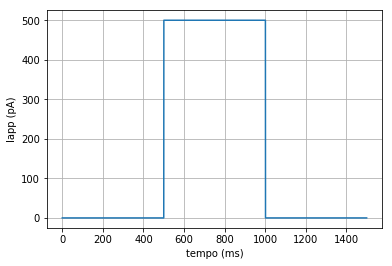

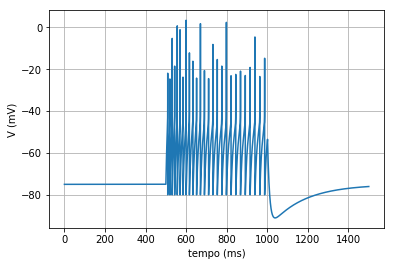

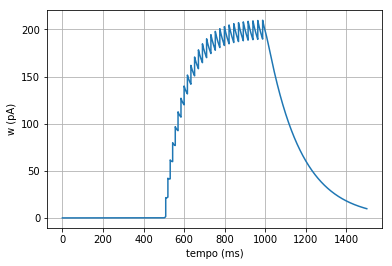

In [2]:
"""
Implements the dynamics of the exponential Integrate-and-fire model

Args:
    tau (Quantity): Membrane time constant
    R (Quantity): Membrane resistance
    v_rest (Quantity): Resting potential
    v_reset (Quantity): Reset value (vm after spike)
    v_rheobase (Quantity): Rheobase threshold
    v_spike (Quantity) : voltage threshold for the spike condition
    delta_T (Quantity): Sharpness of the exponential term
    I_stim (TimedArray): Input current
    simulation_time (Quantity): Duration for which the model is simulated
"""
v_rest= -75*b2.mV #EL
v_reset= -80*b2.mV #Vreset
conductance_L = 10*b2.nsiemens #GL
membrane_capacitance = 100*b2.pF #CM
firing_threshold = -50 * b2.mV #Vth
deltaVth = 2*b2.mV

a = 2*b2.nsiemens
b = 0.02*b2.nA

tau_w = 200*b2.ms
v_max = 20*b2.mV

simulation_time = 1500
dt =  0.001 * b2.ms 

#current = 200.01 * b2.pamp
current = 500
input_current = input_factory.get_step_current(
t_start=500, t_end=1000, unit_time=b2.ms,
amplitude=current*b2.pA) 

# differential equation of Leaky Integrate-and-Fire model
eqs = """

dv/dt = (conductance_L/membrane_capacitance)*(v_rest - v + deltaVth*exp((v-firing_threshold)/deltaVth))
        - (w/membrane_capacitance)
        + (input_current(t,i)/membrane_capacitance) : volt
dw/dt = (a*(v-v_rest)-w)/tau_w :  amp
"""
neuron = b2.NeuronGroup(1, model=eqs, reset="v=v_reset; w=w+b", threshold="v>v_max", method="euler", dt=dt)
neuron.v = v_rest
neuron.w = 0*b2.pA

# monitoring membrane potential of neuron and injecting current
state_monitor = b2.StateMonitor(neuron, ["v", "w"], record=True)
spike_monitor = b2.SpikeMonitor(neuron)
# run the simulation
b2.run(simulation_time*b2.ms)

print("nr of spikes: {}".format(spike_monitor.count[0]))
print("spikes times: {}".format(spike_monitor.t[:]))

plt.figure(1)
c = input_current(state_monitor.t, 0)
plt.plot(state_monitor.t/b2.ms, c/b2.pA )
plt.xlabel('tempo (ms)')
plt.ylabel('Iapp (pA)')
plt.grid()
plt.figure(2)
#axis_v = plt.subplot(312)

plt.plot(state_monitor.t/b2.ms, state_monitor.v[0]/b2.mV)
plt.xlabel('tempo (ms)')
plt.ylabel('V (mV)')
plt.grid()
#plt.legend(["vm", "firing threshold"], fontsize=12)
plt.figure(3)

plt.plot(state_monitor.t/b2.ms, state_monitor.w[0]/b2.pA)
plt.grid()
plt.xlabel('tempo (ms)')
plt.ylabel('w (pA)')

plt.show()


In [ ]:
v_rest= -75*b2.mV #EL
v_reset= -80*b2.mV #Vreset
conductance_L = 10*b2.nsiemens #GL
membrane_capacitance = 100*b2.pF #CM
firing_threshold = -50 * b2.mV #Vth
deltaVth = 2*b2.mV

a = 2*b2.nsiemens
b = 0.02*b2.nA

tau_w = 200*b2.ms
v_max = 20*b2.mV

#current = 200.01 * b2.pamp
input_current = np.arange(300, 600, 10)
# differential equation of Leaky Integrate-and-Fire model
eqs = """

dv/dt = (conductance_L/membrane_capacitance)*(v_rest - v + deltaVth*exp((v-firing_threshold)/deltaVth))
        - (w/membrane_capacitance)
        + (input_current/membrane_capacitance) : volt
dw/dt = (a/tau_w) * (v - v_rest) - (w/tau_w) : ampere
input_current : amp
"""
neuron = b2.NeuronGroup(len(input_current), model=eqs, reset="v=v_reset; w=w+b", threshold="v>v_max", method="euler")
neuron.v = v_rest
neuron.w = 0*b2.pA
neuron.input_current = input_current*b2.pA

# monitoring membrane potential of neuron and injecting current
state_monitor = b2.StateMonitor(neuron, ["v","w"], record=True)
spike_monitor = b2.SpikeMonitor(neuron)
# run the simulation
b2.run(simulation_time*b2.second)

#plot
# input_current = [None]*len(current)
# for i in range(len(current)):
#     input_current[i] = input_factory.get_step_current(t_start=0, t_end=simulation_time, unit_time=b2.second,
#     amplitude= current[i]*b2.nA) 
#     plot_tools.plot_voltage_and_current_traces(
#     state_monitor, input_current[i], title="min input", firing_threshold=firing_threshold)

plt.figure(2)
print("nr of spikes: {}".format(spike_monitor.count))
print("spikes times: {}".format(spike_monitor.t[:]))

print("spikes train: {}".format(spike_monitor.spike_trains()[0][0]))

first_inter = [None]*len(input_current)
stationary_inter = [None]*len(input_current)
for i in range(len(input_current)):
    first_inter[i] = 1/(float(spike_monitor.spike_trains()[i][2]) - float(spike_monitor.spike_trains()[i][1]))
    stationary_inter[i] = 1/(float(spike_monitor.spike_trains()[i][-2]) - float(spike_monitor.spike_trains()[i][-3]))
    
print(first_inter)
print(stationary_inter)
plt.plot(neuron.input_current/b2.pA, spike_monitor.count/simulation_time, '*', label='count')
plt.plot(neuron.input_current/b2.pA, first_inter/b2.second, 's', label='first_inter')
plt.plot(neuron.input_current/b2.pA, stationary_inter/b2.second, 'o', label='stationary_inter')
plt.xlabel('I (nA)')
plt.ylabel('Firing rate (sp/s)')
plt.legend()
plt.show()

WARNING    "input_current" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value array([300, 310, 320, ..., 570, 580, 590]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
